# [source](https://towardsdatascience.com/building-a-linear-regression-with-pyspark-and-mllib-d065c3ba246a)

- learn how to do linear regression decision tree and Gradient boosting on Boston housing prices 



In [2]:
from pyspark import SparkConf,SparkContext
from pyspark.sql import SQLContext

In [3]:
sc = SparkContext()
sqlContext = SQLContext(sc)

In [5]:
house_df = sqlContext.read.format('com.databricks.spark.csv').options(header='true',inferschema='true').load('data/Boston.csv')
house_df.take(1)

[Row(_c0=1, crim=0.00632, zn=18.0, indus=2.31, chas=0, nox=0.538, rm=6.575, age=65.2, dis=4.09, rad=1, tax=296, ptratio=15.3, black=396.9, lstat=4.98, medv=24.0)]

In [21]:
house_df.columns

['_c0',
 'crim',
 'zn',
 'indus',
 'chas',
 'nox',
 'rm',
 'age',
 'dis',
 'rad',
 'tax',
 'ptratio',
 'black',
 'lstat',
 'medv']

# Data exploration

Print Schema in a tree format.

In [6]:
house_df.cache()
house_df.printSchema()

root
 |-- _c0: integer (nullable = true)
 |-- crim: double (nullable = true)
 |-- zn: double (nullable = true)
 |-- indus: double (nullable = true)
 |-- chas: integer (nullable = true)
 |-- nox: double (nullable = true)
 |-- rm: double (nullable = true)
 |-- age: double (nullable = true)
 |-- dis: double (nullable = true)
 |-- rad: integer (nullable = true)
 |-- tax: integer (nullable = true)
 |-- ptratio: double (nullable = true)
 |-- black: double (nullable = true)
 |-- lstat: double (nullable = true)
 |-- medv: double (nullable = true)



In [7]:
# Perform descriptive analytics
house_df.describe().toPandas().transpose()

,0,1,2,3,4
summary,count,mean,stddev,min,max
_c0,506,253.5,146.2138844296259,1,506
crim,506,3.6135235573122535,8.601545105332491,0.00632,88.9762
zn,506,11.363636363636363,23.32245299451514,0.0,100.0
indus,506,11.136778656126504,6.860352940897589,0.46,27.74
chas,506,0.0691699604743083,0.2539940413404101,0,1
nox,506,0.5546950592885372,0.11587767566755584,0.385,0.871
rm,506,6.284634387351787,0.7026171434153232,3.561,8.78
age,506,68.57490118577078,28.148861406903595,2.9,100.0
dis,506,3.795042687747034,2.10571012662761,1.1296,12.1265


Scatter matrix is a great way to roughly determine if we have a linear correlation between multiple independent variables.

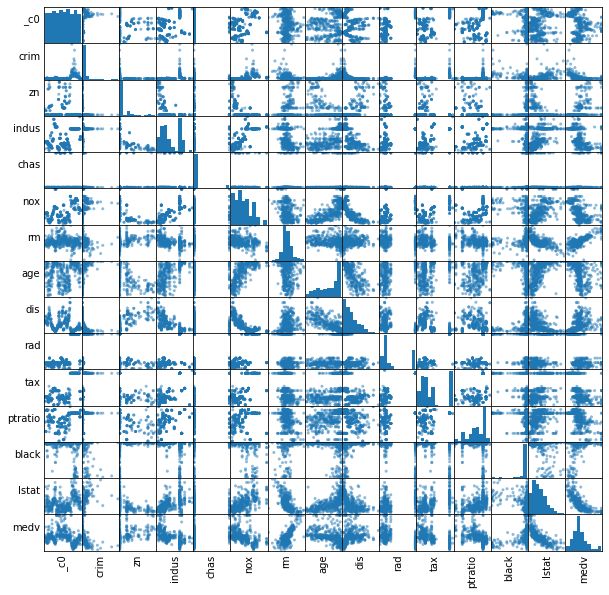

In [10]:
import pandas as pd
from pandas.plotting import scatter_matrix

numeric_features = [t[0] for t in house_df.dtypes if t[1] == 'int' or t[1] == 'double']
sampled_data = house_df.select(numeric_features).sample(False, 0.8).toPandas()
axs = scatter_matrix(sampled_data, figsize=(10, 10))
n = len(sampled_data.columns)
for i in range(n):
    v = axs[i, 0]
    v.yaxis.label.set_rotation(0)
    v.yaxis.label.set_ha('right')
    v.set_yticks(())
    h = axs[n-1, i]
    h.xaxis.label.set_rotation(90)
    h.set_xticks(())

In [17]:
# It’s hard to see. Let’s find correlation between independent variables and target variable.
import six
for i in house_df.columns:
    if not(isinstance(house_df.select(i).take(1)[0][0], six.string_types)):
        print("Correlation to medv for", i, house_df.stat.corr('medv',i))

Correlation to medv for _c0 -0.22660364293533927
Correlation to medv for crim -0.38830460858681154
Correlation to medv for zn 0.3604453424505433
Correlation to medv for indus -0.4837251600283728
Correlation to medv for chas 0.1752601771902987
Correlation to medv for nox -0.4273207723732821
Correlation to medv for rm 0.6953599470715401
Correlation to medv for age -0.3769545650045961
Correlation to medv for dis 0.249928734085904
Correlation to medv for rad -0.38162623063977735
Correlation to medv for tax -0.46853593356776674
Correlation to medv for ptratio -0.5077866855375622
Correlation to medv for black 0.3334608196570661
Correlation to medv for lstat -0.7376627261740145
Correlation to medv for medv 1.0


In [22]:
# Prepare data for Machine Learning. And we need two columns only — features and label(“MV”):

from pyspark.ml.feature import VectorAssembler

vectorAssembler = VectorAssembler(inputCols = ['crim','zn','indus',
                                                             'chas',
                                                             'nox',
                                                             'rm',
                                                             'age',
                                                             'dis',
                                                             'rad',
                                                             'tax',
                                                             'ptratio',
                                                             'black',
                                                             'lstat'], outputCol = 'features')
vhouse_df = vectorAssembler.transform(house_df)
vhouse_df = vhouse_df.select(['features', 'medv'])
vhouse_df.show(3)

+--------------------+----+
|            features|medv|
+--------------------+----+
|[0.00632,18.0,2.3...|24.0|
|[0.02731,0.0,7.07...|21.6|
|[0.02729,0.0,7.07...|34.7|
+--------------------+----+
only showing top 3 rows



In [23]:
# DATA SPLIT

splits = vhouse_df.randomSplit([0.7, 0.3])
train_df = splits[0]
test_df = splits[1]

# Linear Regression

In [27]:

from pyspark.ml.regression import LinearRegression


lr = LinearRegression(featuresCol = 'features', labelCol='medv', maxIter=10, regParam=0.3, elasticNetParam=0.8)
lr_model = lr.fit(train_df)
print("Coefficients: " + str(lr_model.coefficients))
print("Intercept: " + str(lr_model.intercept))

Coefficients: [-0.014709579812006743,0.011207718612157315,0.0,1.4579398440507403,-6.758479567854248,4.309632648548865,0.0,-0.7193574563697109,0.0,0.0,-0.8784858003733893,0.007062152314448821,-0.5528770297381946]
Intercept: 22.419499796081183


In [28]:
# Summarize the model over the training set and print out some metrics:


trainingSummary = lr_model.summary
print("RMSE: %f" % trainingSummary.rootMeanSquaredError)
print("r2: %f" % trainingSummary.r2)

RMSE: 4.924299
r2: 0.731742


In [29]:
train_df.describe().show()

+-------+-----------------+
|summary|             medv|
+-------+-----------------+
|  count|              359|
|   mean|22.64178272980503|
| stddev|9.520814196183455|
|    min|              5.6|
|    max|             50.0|
+-------+-----------------+



In [30]:
#  performance on the test set.

from pyspark.ml.evaluation import RegressionEvaluator

lr_predictions = lr_model.transform(test_df)
lr_predictions.select("prediction","medv","features").show(5)
lr_evaluator = RegressionEvaluator(predictionCol="prediction", \
                 labelCol="medv",metricName="r2")
print("R Squared (R2) on test data = %g" % lr_evaluator.evaluate(lr_predictions))

+------------------+----+--------------------+
|        prediction|medv|            features|
+------------------+----+--------------------+
|31.021440179626065|32.2|[0.00906,90.0,2.9...|
|30.100781003139975|35.4|[0.01311,90.0,1.2...|
|31.473994884691297|31.6|[0.01432,100.0,1....|
|27.482937700748266|24.5|[0.01501,80.0,2.0...|
| 35.37222840782385|44.0|[0.01538,90.0,3.7...|
+------------------+----+--------------------+
only showing top 5 rows

R Squared (R2) on test data = 0.667271


In [31]:
test_result = lr_model.evaluate(test_df)
print("Root Mean Squared Error (RMSE) on test data = %g" % test_result.rootMeanSquaredError)

Root Mean Squared Error (RMSE) on test data = 4.81678


In [32]:
print("numIterations: %d" % trainingSummary.totalIterations)
print("objectiveHistory: %s" % str(trainingSummary.objectiveHistory))
trainingSummary.residuals.show()

numIterations: 11
objectiveHistory: [0.5000000000000004, 0.43350575437045696, 0.2279972974804714, 0.20259379030682045, 0.1742500195899413, 0.171561725199606, 0.170982705199255, 0.17023271181457167, 0.16955280410509327, 0.16885086546774977, 0.16881315930482993]
+--------------------+
|           residuals|
+--------------------+
|  -6.987554326502359|
| -5.7567753521162714|
|  0.5964960216049917|
|   2.217123894245418|
|  11.169153777888383|
|  -1.802632211401928|
|   8.813711754199531|
|  3.8782034349509225|
| -2.8443344118951757|
|   7.229162209557071|
| -0.1997308855156099|
|  10.134252087391872|
| -1.2151570485299494|
|  5.3159745084969146|
|-0.40556619261254667|
| -10.098742596185403|
|  -3.970278576832989|
|  3.1499547701922594|
|  -3.861026930082449|
|  1.5669708242941631|
+--------------------+
only showing top 20 rows



In [34]:
predictions = lr_model.transform(test_df)
predictions.select("prediction","medv","features").show()

+------------------+----+--------------------+
|        prediction|medv|            features|
+------------------+----+--------------------+
|31.021440179626065|32.2|[0.00906,90.0,2.9...|
|30.100781003139975|35.4|[0.01311,90.0,1.2...|
|31.473994884691297|31.6|[0.01432,100.0,1....|
|27.482937700748266|24.5|[0.01501,80.0,2.0...|
| 35.37222840782385|44.0|[0.01538,90.0,3.7...|
| 31.32342659863811|32.9|[0.01778,95.0,1.4...|
|19.971402002259754|17.5|[0.03113,0.0,4.39...|
|30.661850205326125|34.9|[0.0315,95.0,1.47...|
| 29.85535474088418|33.4|[0.03237,0.0,2.18...|
|32.375435540901854|34.9|[0.03359,75.0,2.9...|
|28.343692065237047|24.1|[0.03445,82.5,2.0...|
|22.626522986892656|20.9|[0.03548,80.0,3.6...|
| 29.05468390100713|23.5|[0.03584,80.0,3.3...|
|28.767497440893695|27.9|[0.03615,80.0,4.9...|
|25.490717785162605|24.8|[0.03659,25.0,4.8...|
| 34.71643063576684|34.6|[0.03768,80.0,1.5...|
| 36.20991988733195|33.3|[0.04011,80.0,1.5...|
|28.112859031829146|28.0|[0.04113,25.0,4.8...|
|24.886725926

# Decision tree regression

In [36]:
from pyspark.ml.regression import DecisionTreeRegressor


dt = DecisionTreeRegressor(featuresCol ='features', labelCol = 'medv')
dt_model = dt.fit(train_df)
dt_predictions = dt_model.transform(test_df)
dt_evaluator = RegressionEvaluator(
    labelCol="medv", predictionCol="prediction", metricName="rmse")
rmse = dt_evaluator.evaluate(dt_predictions)


print("Root Mean Squared Error (RMSE) on test data = %g" % rmse)

Root Mean Squared Error (RMSE) on test data = 4.36076


In [37]:
# Feature Importance
dt_model.featureImportances

SparseVector(13, {0: 0.0381, 4: 0.0547, 5: 0.5532, 6: 0.0138, 7: 0.0499, 10: 0.0084, 11: 0.0042, 12: 0.2778})

In [38]:
house_df.columns

['_c0',
 'crim',
 'zn',
 'indus',
 'chas',
 'nox',
 'rm',
 'age',
 'dis',
 'rad',
 'tax',
 'ptratio',
 'black',
 'lstat',
 'medv']

In [39]:
house_df.take(1)

[Row(_c0=1, crim=0.00632, zn=18.0, indus=2.31, chas=0, nox=0.538, rm=6.575, age=65.2, dis=4.09, rad=1, tax=296, ptratio=15.3, black=396.9, lstat=4.98, medv=24.0)]

# Gradient-boosted tree regression

In [41]:

from pyspark.ml.regression import GBTRegressor


gbt = GBTRegressor(featuresCol = 'features', labelCol = 'medv', maxIter=10)
gbt_model = gbt.fit(train_df)
gbt_predictions = gbt_model.transform(test_df)
gbt_predictions.select('prediction', 'medv', 'features').show(5)

+------------------+----+--------------------+
|        prediction|medv|            features|
+------------------+----+--------------------+
|31.738710705349742|32.2|[0.00906,90.0,2.9...|
|32.493604759277034|35.4|[0.01311,90.0,1.2...|
|31.033297039785488|31.6|[0.01432,100.0,1....|
|23.989099479319194|24.5|[0.01501,80.0,2.0...|
| 41.09249115344174|44.0|[0.01538,90.0,3.7...|
+------------------+----+--------------------+
only showing top 5 rows



In [42]:
gbt_evaluator = RegressionEvaluator(
    labelCol="medv", predictionCol="prediction", metricName="rmse")
rmse = gbt_evaluator.evaluate(gbt_predictions)
print("Root Mean Squared Error (RMSE) on test data = %g" % rmse)

Root Mean Squared Error (RMSE) on test data = 4.16777
